# Predict the topic of a Math Question on Math Education Resources

We will use **Machine Learning** to predict the topic of a Math Question from the [Math Education Resources](http://math-education-resources.com). For simplicity we will only consider two topics. Using [multiclass classification](https://en.wikipedia.org/wiki/Multiclass_classification) this can be extended to more than two topics (at the time of writing, April 2015, we have about 1500 questions with 150 topics on MER).

## Data inspection

To Do:
1. Clean up the code
2. Get feature importance - pca
3. Get the text -> vector of suggested topics
4. Look at performance of different classifiers
   a. Add additional features (course etc.)
5. Add the suggested topics to the database for questions w/o a topic

In [90]:
import os
import json
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
client = MongoClient()

In [3]:
questions_collection = client['merdb'].questions

questions_collection.find_one()

{u'ID': u'UBC+MATH307+April_2012+01_(d)',
 u'_id': ObjectId('55383310cec2a2367cebc622'),
 u'answer_html': u'<p>No content found.</p>',
 u'answer_latex': u'No content found.',
 u'contributors': [u'Konradbe'],
 u'course': u'MATH307',
 u'flags': [u'RQ', u'CH', u'CS', u'CT'],
 u'hints_html': [u'<p>No content found.</p>'],
 u'hints_latex': [u'No content found.'],
 u'hints_raw': [u'No content found.'],
 u'num_votes': 0,
 u'question': u'1 (d)',
 u'rating': -1,
 u'sols_html': [u'<p>No content found.</p>'],
 u'sols_latex': [u'No content found.'],
 u'sols_raw': [u'No content found.'],
 u'statement_html': u'<p>Suppose you are given a set of <em>N</em> data points <em>(x<sub>n</sub>, y<sub>n</sub>)</em>, with <em>x<sub>n</sub></em> increasing, and you wish to interpolate these points with a spline function <em><span class="math">\\(f\\)</span></em>, where <em><span class="math">\\(f\\)</span>(x)</em> is given by the cubic polynomial <em>p<sub>n</sub>(x)</em> on each interval <em>(x<sub>n</sub>, x<

In [4]:
# create an array of all topics of interest

topic_tags = ["Eigenvalues_and_eigenvectors", "Probability_density_function", "Taylor_series", "Substitution"]

num_classes = len(topic_tags)

In [5]:
# create an array of questions with topics contained in topic_tags

questions = []
for q in questions_collection.find({"topics": 
                                         {"$in": topic_tags}
                                        }):
    questions.append(q)


In [6]:
# count how many questions there are for each topic in topic_tags

for t in topic_tags:
    print(t, questions_collection.find({"topics": t}).count())
    

('Eigenvalues_and_eigenvectors', 45)
('Probability_density_function', 39)
('Taylor_series', 50)
('Substitution', 37)


In [7]:
questions[77].keys()

[u'rating',
 u'contributors',
 u'topics',
 u'year',
 u'answer_html',
 u'course',
 u'solvers',
 u'sols_raw',
 u'hints_html',
 u'question',
 u'statement_raw',
 u'num_votes',
 u'statement_html',
 u'term',
 u'statement_latex',
 u'hints_raw',
 u'hints_latex',
 u'ID',
 u'sols_latex',
 u'url',
 u'flags',
 u'answer_latex',
 u'sols_html',
 u'_id']

In [8]:
# data preprocessing modules

import helpers
from nltk import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import label_binarize

In [9]:
# split the questions into training and test


# for reproducibility we set the seed of the random number generator
np.random.seed(23)

test_proportion = 0.75
num_samples = int(test_proportion * len(questions))
test_indices = np.random.choice(range(len(questions)), num_samples, replace=False)


questions_train = [q for i, q in enumerate(questions) if not i in test_indices]
questions_test = [q for i, q in enumerate(questions) if i in test_indices]

for topic in topic_tags:
    print('%s questions in test set: %d' % (topic, sum([1 for q in questions_test if topic in q['topics']])))

Eigenvalues_and_eigenvectors questions in test set: 30
Probability_density_function questions in test set: 32
Taylor_series questions in test set: 40
Substitution questions in test set: 26


In [10]:
# clean & filter data
def words_from_question(q):
    # we are only interested in question statement, hints and solution
    all_text = q['statement_html'] + q['hints_html'][0] + q['sols_html'][0] 
    return helpers.strip_text(all_text)

# remove commonly used words and combine words with the same root
def words_stemmed_no_stop(words):
    stop = stopwords.words('english')
    res = []
    for word in words:
        stemmed = PorterStemmer().stem_word(word)
        if stemmed not in stop and len(stemmed) > 1: #take words longer than 1 char
            res.append(stemmed)
    return res

In [11]:
# collect all stemmed words from training set, excluding stop words

vocabulary = []

for q in questions_train:
    vocabulary += words_stemmed_no_stop(words_from_question(q))
vocabulary_sorted = sorted(set(vocabulary))



print('Number of distinct words:', len(vocabulary_sorted))
print(vocabulary_sorted[:15])

('Number of distinct words:', 462)
[u'abov', u'accord', u'ad', u'addit', u'age', u'ahead', u'allow', u'almost', u'also', u'altern', u'alway', u'analyt', u'ani', u'anoth', u'answer']


In [12]:
# returns a binary vector for a question, indicating whether a word
# from vocabulary is contained in the question

def question_to_vector(q, voc):
    # vector of dimension 1xlen(voc)
    x_vec = np.zeros(len(voc))
    words = words_stemmed_no_stop(words_from_question(q))
    for word in words:
        if word in voc:
            x_vec[voc.index(word)] = 1
    return x_vec

In [13]:
print(question_to_vector(questions[0], vocabulary))
sum(question_to_vector(questions[0], vocabulary))

[ 1.  1.  1. ...,  0.  0.  0.]


24.0

In [60]:
# create an array of numerical labels for classes

class_indices = range(0, num_classes)

# transform questions into appropriate labels
def questions_to_topic_index(qs):
    topic_labels = []
    for q in qs:
        # go through topic_tags, if any of the topics is in the question's topic list
        # append its index to topic_labels
        for i in class_indices:
            if topic_tags[i] in q['topics']:
                topic_labels.append(i)
                # assumes there is only one topic for each question
                break 
                
    return np.asarray(topic_labels)

def questions_to_y(qs):
    return label_binarize(questions_to_topic_index(qs), class_indices)

In [61]:
def questions_to_X(qs, voc):
    X = np.zeros(shape=(len(qs), len(voc)))

    for i, q in enumerate(qs):
        X[i, :] = question_to_vector(q, voc)
    return X

In [62]:
X_train = questions_to_X(questions_train, vocabulary_sorted)
X_test = questions_to_X(questions_test, vocabulary_sorted)

In [63]:
assert len(X_train) == len(questions_train)

In [64]:
y_train = questions_to_y(questions_train)
y_test = questions_to_y(questions_test)

In [19]:
# machine learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

In [20]:
# SVM classifier

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability = True, random_state=np.random.RandomState(0)))

In [21]:
trained_classifier = classifier.fit(X_train, y_train)

In [86]:
preds = trained_classifier.predict_proba(X_test)

#print(np.around(preds, 3))

def pred_to_topic(pred_array):
    return(topic_tags[np.argmax(pred_array)])

def preds_to_topics(preds_array):
    result = []
    for p in preds_array:
        result.append(pred_to_topic(p))
    return result

predicted_classes = preds_to_topics(preds)
print(predicted_classes)

['Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Eigenvalues_and_eigenvectors', 'Taylor_series', 'Substitution', 'Substitution', 'Taylor_series', 'Substitution', 'Probability_density_function', 'Taylor_series', 'Taylor_series', 'Probability_density_function', 'Substitution', 'Substitution', 'Taylor_series', 'Probability_density_function', 'Substitution', 'Taylor_series', 'Substitution', 'Substitution', 'Taylor_series', 'Substitution', 'Probability_density_function', 

In [25]:
# code not edited

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(roc_auc)

{0: 1.0, 1: 0.99671052631578949, 2: 0.99770114942528731, 3: 0.99764705882352933, 'micro': 0.99801599603199209}


In [26]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [27]:
pca = PCA(n_components=3)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)
print('The first 3 principal components explain %.2f of the variance in the dataset.' % sum(pca.explained_variance_ratio_))

The first 3 principal components explain 0.21 of the variance in the dataset.


In [28]:
print(y_train)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [ ]:
#labels_train = [TOPIC1 if _ else TOPIC0 for _ in y_train]
#labels_test = [TOPIC1 if _ else TOPIC0 for _ in y_test]
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=70)
for c, i, label in zip('rgb', class_indices, labels_train):
    ax.scatter(pca_X_train[y_train == i, 0],
               pca_X_train[y_train == i, 1],
               pca_X_train[y_train == i, 2],
               c=c, label=label)
    
    
for c, i, label in zip('rgb', [0, 1], [l + ' (test)' for l in labels_test]):
    ax.scatter(pca_X_test[y_test == i, 0],
               pca_X_test[y_test == i, 1],
               pca_X_test[y_test == i, 2],
               c=c, label=label, marker='x')
plt.legend()
plt.show()

[ 0.12234723  0.99858668  0.88826215  0.95964481]
0.564785449158


ValueError: Cannot convert argument type <type 'numpy.ndarray'> to rgba array

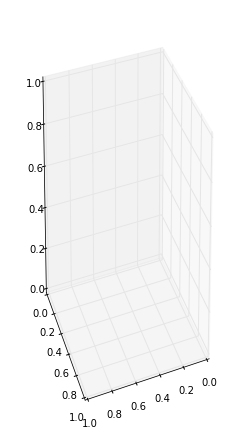

In [76]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, .5, .4, 1], elev=25, azim=70)

y_index_train = questions_to_topic_index(questions_train)

print(np.random.rand(num_classes,))

for col, i in zip(np.random.rand(num_classes,), range(num_classes)):
    print(col)
    ax.scatter(pca_X_train[y_index_train==i,0],
           pca_X_train[y_index_train==i,1],
           pca_X_train[y_index_train==i,2],
          c=col, label = topic_tags[i])
plt.legend()
plt.show()

## fix colours (e.g. through random number generator mapped to random cols)


In [87]:
def predict_topic_for_question(q, classifier, voc):
    vec = question_to_vector(q, voc)
    pred_prob = classifier.predict_proba(vec)
    pred_class = pred_to_topic(pred_prob)
    return pred_class
    

In [89]:
print(predict_topic_for_question(questions[77], trained_classifier, vocabulary_sorted))

Probability_density_function


In [91]:
pickle.dump(trained_classifier, open("svm.p", "wb"))